**Load Dataset**

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Install kaggle library
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smmmmmmmm","key":"7b133f9532960b035175029dd9cafb37"}'}

In [3]:
# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d manjeetsingh/retaildataset
!unzip retaildataset.zip

Dataset URL: https://www.kaggle.com/datasets/manjeetsingh/retaildataset
License(s): CC0-1.0
  0% 0.00/3.11M [00:00<?, ?B/s]
100% 3.11M/3.11M [00:00<00:00, 124MB/s]
Archive:  retaildataset.zip
  inflating: Features data set.csv   
  inflating: sales data-set.csv      
  inflating: stores data-set.csv     


In [4]:
df = pd.read_csv("sales data-set.csv")

# Basic information about the dataset
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


**Exploratory Data Analysis**


---


Distribution of Sales Amount

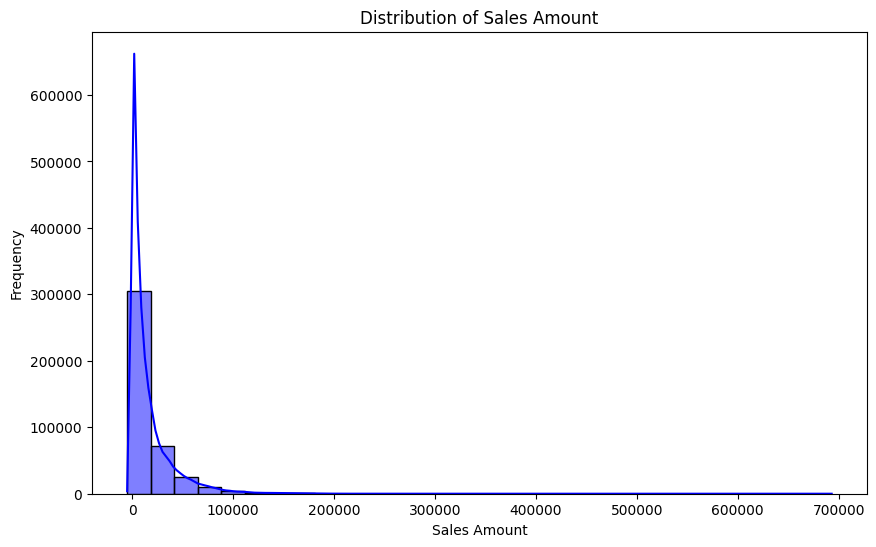

In [ ]:
# Distribution of Sales Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sales Amount')
plt.xlabel('Sales Amount')
plt.ylabel('Frequency')
plt.show()


Total Sales by Store

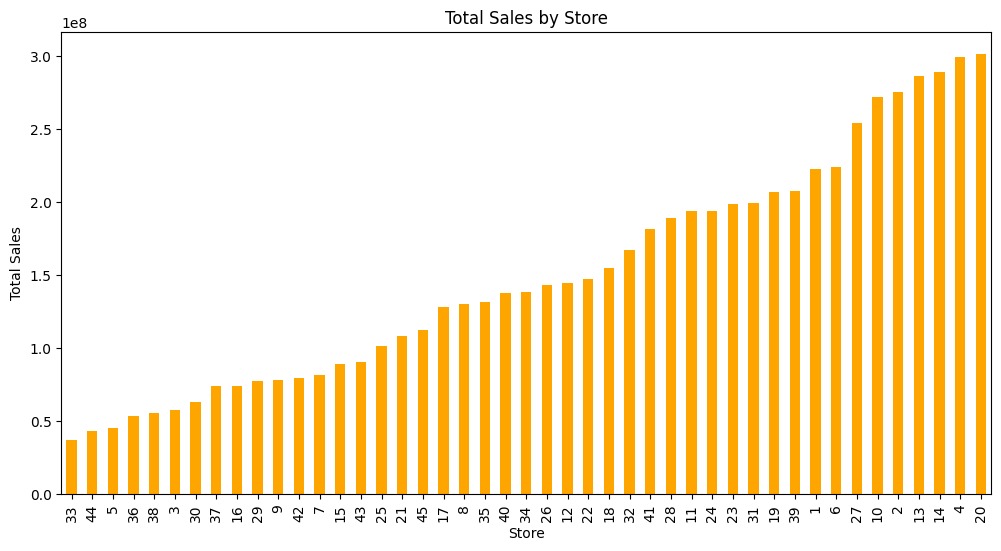

In [ ]:
# Sales by Store
plt.figure(figsize=(12, 6))
category_sales = df.groupby('Store')['Weekly_Sales'].sum().sort_values()
category_sales.plot(kind='bar', color='orange')
plt.title('Total Sales by Store')
plt.ylabel('Total Sales')
plt.show()

Total Sales by Dept

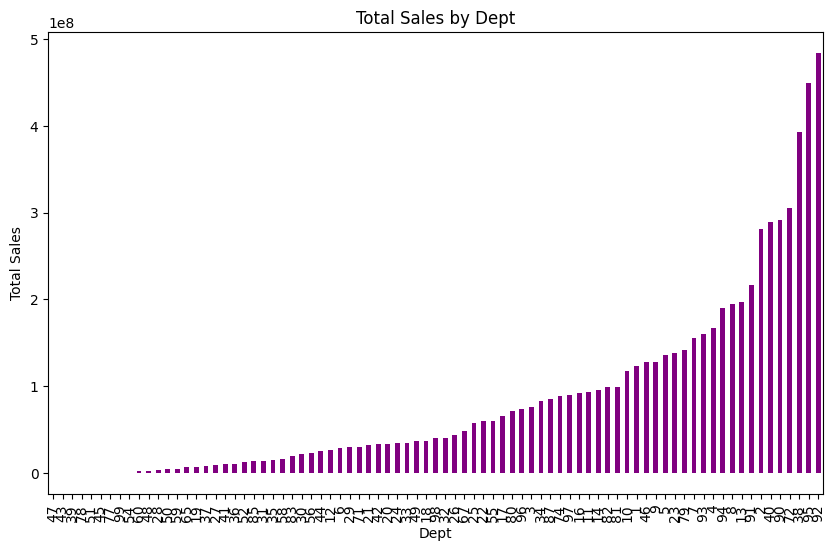

In [ ]:
# Sales by Dept
plt.figure(figsize=(10, 6))
region_sales = df.groupby('Dept')['Weekly_Sales'].sum().sort_values()
region_sales.plot(kind='bar', color='purple')
plt.title('Total Sales by Dept')
plt.ylabel('Total Sales')
plt.show()


**Machine Learning Models**


---

Data Preprocessing

In [ ]:
# Create lag features for time-series analysis
df['Sales_Lag_1'] = df['Weekly_Sales'].shift(1)
df['Sales_Lag_7'] = df['Weekly_Sales'].shift(7)

# Encode Categorical Variables
df = pd.get_dummies(df, columns=['Dept', 'Store'], drop_first=True)

# Fill missing lagged values
df.fillna(0, inplace=True)


Model Training


In [6]:
# Define features and target variable
X = df.drop(columns=['Weekly_Sales', 'Date'])
y = df['Weekly_Sales']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    print(f"Model: {name}")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")
    print("-" * 30)


Model: Linear Regression
MAE: 2557.76, RMSE: 7047.14, R2: 0.90
------------------------------
Model: Random Forest
MAE: 2045.38, RMSE: 5791.56, R2: 0.94
------------------------------
Model: Gradient Boosting
MAE: 2170.29, RMSE: 6152.65, R2: 0.93
------------------------------


Hyperparameter Tuning

In [7]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: 7068.045822974078


**Forecasting**

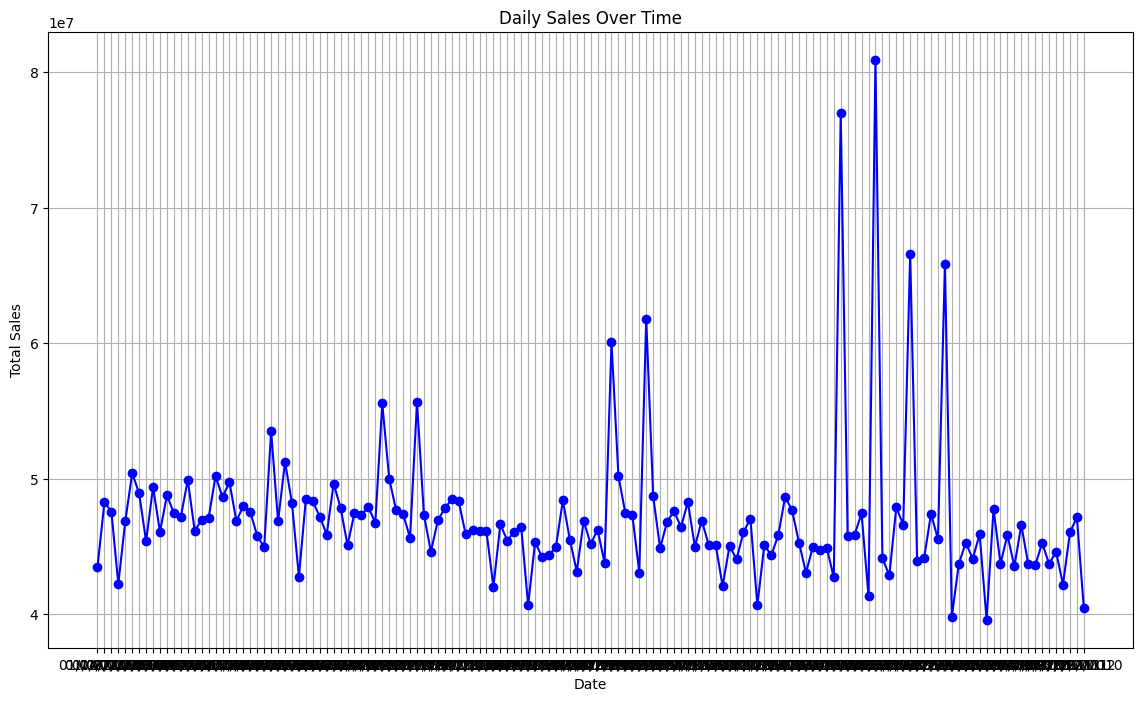

In [8]:
# Aggregate sales by date
daily_sales = df.groupby('Date')['Weekly_Sales'].sum()

# Plot daily sales
plt.figure(figsize=(14, 8))
plt.plot(daily_sales, marker='o', color='blue')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


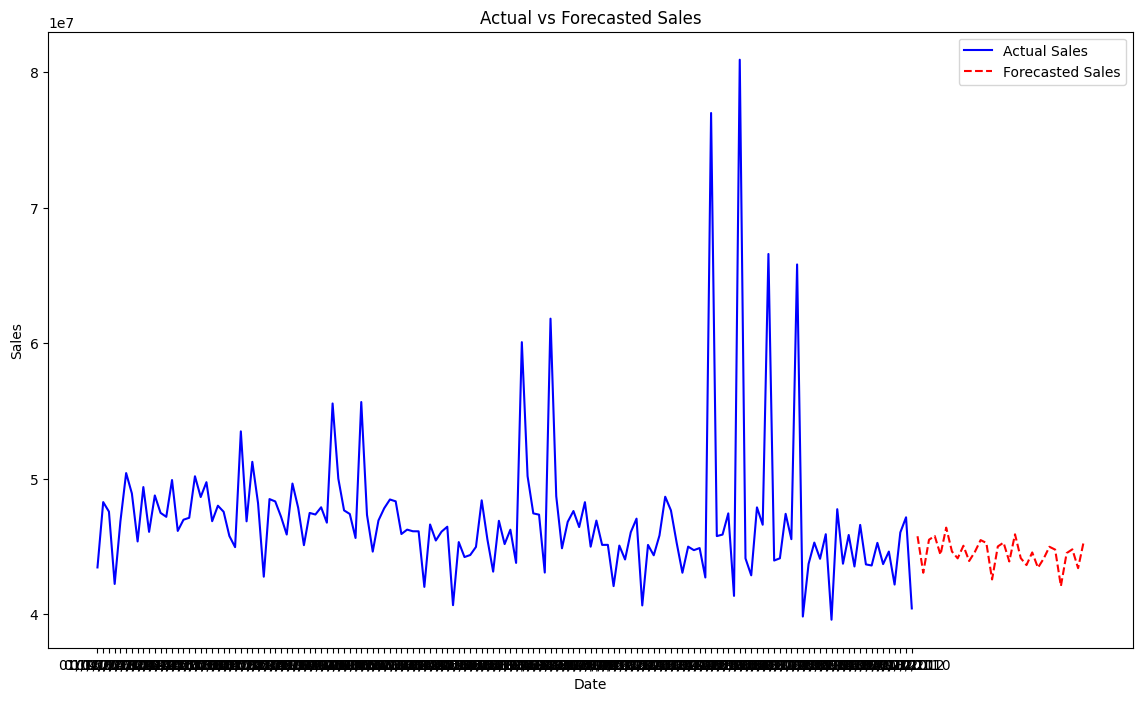

In [9]:
# Apply Exponential Smoothing
model = ExponentialSmoothing(daily_sales, trend='add', seasonal='add', seasonal_periods=12).fit()

# Forecast future sales
forecast = model.forecast(30)

# Plot actual vs forecasted sales
plt.figure(figsize=(14, 8))
plt.plot(daily_sales, label='Actual Sales', color='blue')
plt.plot(forecast, label='Forecasted Sales', color='red', linestyle='--')
plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
